In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [0]:
sc = spark.sparkContext
file = sc.textFile("/FileStore/tables/fooddelivery") 
print(file)

/FileStore/tables/fooddelivery MapPartitionsRDD[998] at textFile at NativeMethodAccessorImpl.java:0


In [0]:
#first line of file
file.first()

Out[262]: 'Key business metrics or performance metrics (KPIs) that you would like to monitor for a food delivery service? (Enter minimum three)'

In [0]:
#first few lines of file
file.take(10)

Out[263]: ['Key business metrics or performance metrics (KPIs) that you would like to monitor for a food delivery service? (Enter minimum three)',
 'on time delivery , failed payment , ratings stats(by rider , by user) , resto. rating ',
 'Cost , Distance, Type of food, frequency of certain order types, Storage type, manpower.',
 '"1. Delivery time',
 '2. Service area',
 '3. Customer\'s taste preference "',
 '"1. number of completed deliveries',
 '2. Average cost of delivery',
 '3. Average time per delivery"',
 'Delivery time, Order amount and frequency per area, Feedback after servicing']

In [0]:
#number of lines in file
file.count()

Out[264]: 225

## Text Preprocessing

In [0]:
#split the text into words

words=file.flatMap(lambda line: line.split(" "))

In [0]:
words.take(10)

Out[266]: ['Key',
 'business',
 'metrics',
 'or',
 'performance',
 'metrics',
 '(KPIs)',
 'that',
 'you',
 'would']

In [0]:
#get word tokens
word_tokens = words.map( lambda word: (word.lower(), 1 ))

In [0]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#stop word removal

key_words = word_tokens.filter(lambda rec: rec[0] not in stop_words)

In [0]:
#remove special characters

pattern = r'[^a-z]'
clean_words = key_words.filter(lambda rec: len(re.sub(pattern, '', rec[0])) > 1)

In [0]:
#clean words
clean_words.take(10)

Out[271]: [('key', 1),
 ('business', 1),
 ('metrics', 1),
 ('performance', 1),
 ('metrics', 1),
 ('(kpis)', 1),
 ('would', 1),
 ('like', 1),
 ('monitor', 1),
 ('food', 1)]

In [0]:
#count of clean words/ frequency
clean_words_count = clean_words.reduceByKey(lambda a, b: a+b)

## Word Count Analysis

In [0]:
#top clean words frequency

clean_words_sorted = clean_words_count.sortBy(lambda rec: rec[1], ascending = False)

In [0]:
clean_words_sorted.take(20)

Out[274]: [('delivery', 50),
 ('customer', 39),
 ('order', 34),
 ('time', 31),
 ('per', 29),
 ('average', 23),
 ('food', 22),
 ('number', 19),
 ('orders', 16),
 ('restaurant', 12),
 ('rating', 12),
 ('customers', 12),
 ('cost', 10),
 ('frequency', 9),
 ('satisfaction', 9),
 ('rate', 8),
 ('revenue', 8),
 ('order,', 8),
 ('time,', 8),
 ('data', 8)]

In [0]:
# Assuming data1 is a list of tuples (word, count)
df = pd.DataFrame(clean_words_sorted.take(20), columns=['Word', 'Count'])
display(df.head())

Word,Count
delivery,50
customer,39
order,34
time,31
per,29


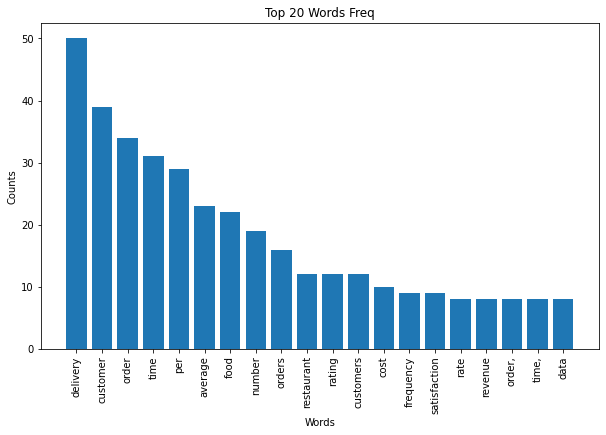

In [0]:
# Assuming data1 is a list of tuples (word, count)
words = [x[0] for x in clean_words_sorted.take(20)]
counts = [x[1] for x in clean_words_sorted.take(20)]

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 20 Words Freq')
plt.xticks(rotation=90)
plt.show()

## Bigram Analysis

In [0]:
def bigrams(line):
    # Split the line into words
    words = line.lower().split()
    
    # Remove special characters and stopwords
    words = [re.sub(r'[^\w\s]', '', word) for word in words if word not in stop_words]
    
    numOfWords = len(words)
    bigrams = []
    
    # Create bigrams
    for idx in range(numOfWords - 1):
        bigram = (words[idx] + " " + words[idx + 1], 1)
        bigrams.append(bigram)
    
    return bigrams


In [0]:
bigram_tokens =file.flatMap( lambda line: bigrams(line))
bigram_tokens.take(5)

Out[278]: [('key business', 1),
 ('business metrics', 1),
 ('metrics performance', 1),
 ('performance metrics', 1),
 ('metrics kpis', 1)]

In [0]:

bigram_counts = bigram_tokens.reduceByKey(lambda a, b: a+b) 
bigram_counts.take(20)

Out[279]: [('key business', 1),
 ('metrics performance', 1),
 ('performance metrics', 2),
 ('kpis would', 1),
 ('would like', 1),
 ('minimum three', 1),
 ('time delivery', 3),
 (' failed', 1),
 ('failed payment', 1),
 ('ratings statsby', 1),
 ('rider ', 1),
 ('user ', 1),
 ('distance type', 1),
 ('type food', 1),
 ('frequency certain', 1),
 ('certain order', 1),
 ('1 delivery', 3),
 ('2 service', 1),
 ('service area', 1),
 ('3 customers', 1)]

In [0]:
bigram_counts.sortBy(lambda rec: rec[1], ascending = False).take(20)

Out[280]: [('delivery time', 16),
 ('average delivery', 7),
 ('customer satisfaction', 7),
 ('orders per', 6),
 ('per order', 6),
 ('order value', 6),
 ('customer retention', 5),
 ('average order', 5),
 ('food delivery', 5),
 ('per delivery', 4),
 ('3 customer', 4),
 ('number orders', 4),
 ('1 average', 4),
 ('time per', 4),
 ('customer rating', 4),
 ('revenue per', 4),
 ('metric plots', 4),
 ('time delivery', 3),
 ('1 delivery', 3),
 ('time order', 3)]

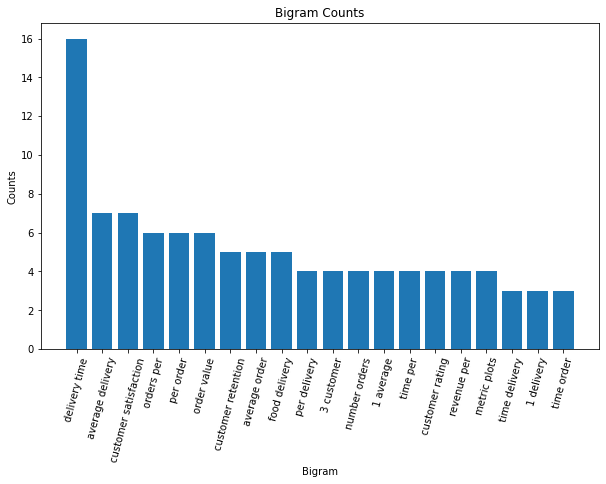

In [0]:
# Assuming data1 is a list of tuples (word, count)
words = [x[0] for x in bigram_counts.sortBy(lambda rec: rec[1], ascending = False).take(20)]
counts = [x[1] for x in bigram_counts.sortBy(lambda rec: rec[1], ascending = False).take(20)]

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Bigram')
plt.ylabel('Counts')
plt.title('Bigram Counts')
plt.xticks(rotation=75)
plt.show()

## Trigram Analysis

In [0]:
def trigrams(line):
    # Split the line into words
    words = line.lower().split()
    
    # Remove special characters and stopwords
    words = [re.sub(r'[^\w\s]', '', word) for word in words if word not in stop_words]
    
    numOfWords = len(words)
    trigrams = []
    
    # Create bigrams
    for idx in range(numOfWords - 2):
        trigram = (words[idx] + " " + words[idx + 1]+" " + words[idx + 2]   , 1)
        trigrams.append(trigram)
    
    return trigrams


In [0]:
(file
.flatMap( lambda line: trigrams(line))
.reduceByKey(lambda a, b: a+b) 
.sortBy(lambda rec: rec[1], ascending = False).take(20))


Out[283]: [('average delivery time', 4),
 ('profit per delivery', 3),
 ('1 average delivery', 3),
 ('average order value', 3),
 ('out 5 star', 2),
 ('food items cart', 2),
 ('2 delivery time', 2),
 ('customer rating delivery', 2),
 ('hygienic food proper', 2),
 ('food proper packaging', 2),
 ('employee behaviour rating', 2),
 ('restaurant highest number', 2),
 ('total amount orders', 2),
 ('delivery time ', 2),
 ('percentage driver order', 2),
 ('food delivery business', 2),
 ('revenue per order', 2),
 ('time per order', 2),
 ('average time per', 2),
 ('number orders per', 2)]

In [0]:
tri_val= (file
.flatMap( lambda line: trigrams(line))
.reduceByKey(lambda a, b: a+b) 
.sortBy(lambda rec: rec[1], ascending = False).take(20))


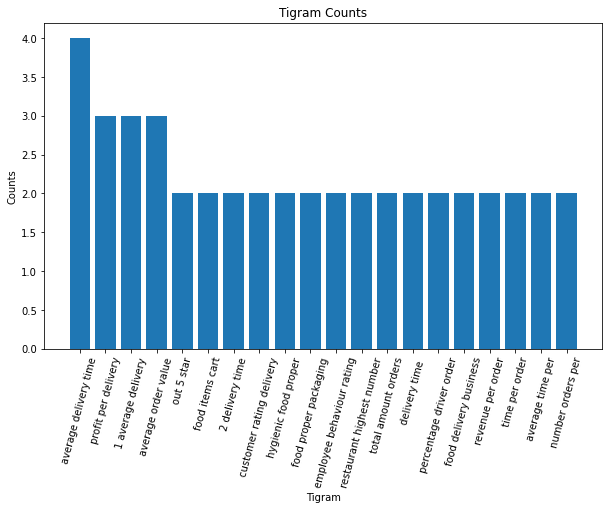

In [0]:
# Assuming data1 is a list of tuples (word, count)
words = [x[0] for x in tri_val]
counts = [x[1] for x in tri_val]

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Tigram')
plt.ylabel('Counts')
plt.title('Tigram Counts')
plt.xticks(rotation=75)
plt.show()

## More Analysis (On Raw Text without any pre processing)

In [0]:
#longest word
file.flatMap(lambda line: line.lower().split()).max(key=lambda word: len(word))


Out[286]: 'application/service.'

In [0]:
(file
.flatMap(lambda line: line.lower().split())
.map(lambda word: (word, len(word)))
.reduce(lambda x, y: x if x[1] > y[1] else y))


Out[287]: ('(resturants/delivery', 20)

In [0]:
#unique words
file.flatMap(lambda line: line.lower().split()).distinct().count()


Out[288]: 739

In [0]:
#average word length
file.flatMap(lambda line: line.lower().split()).map(lambda word: len(word)).mean()


Out[289]: 5.321152856407624

In [0]:
#most common starting letter of words
(file.flatMap(lambda line: line.lower().split())
.map(lambda word: (word[0], 1))
.reduceByKey(lambda x, y: x + y)
.max(key=lambda x: x[1]))


Out[290]: ('o', 232)

In [0]:
#total words

(file.flatMap(lambda line: line.split())
.map(lambda word: ("total word", 1))
.reduceByKey(lambda x, y: x + y)
.take(1))

Out[291]: [('total word', 1943)]

In [0]:
#number of lines
(file
.map(lambda line: ("line", 1))
.reduceByKey(lambda x, y: x + y)
.take(1))



Out[292]: [('line', 225)]

In [0]:
#word start with s

(file.flatMap(lambda line: line.split())
.map(lambda word: ("total word s", word.lower().startswith('s')))
.reduceByKey(lambda x, y: x + y)
.take(1))

Out[293]: [('total word s', 90)]

In [0]:
#start with a

(file.flatMap(lambda line: line.split())
.map(lambda word: (  "word start with a" , word.lower().startswith('a')))
.reduceByKey(lambda x, y: x + y)
.take(1))

Out[294]: [('word start with a', 174)]

In [0]:
#word start with a 

(file.flatMap(lambda line: line.split())
.map(lambda word: (  "word start with a" , word.lower()[0]=='a'))
.reduceByKey(lambda x, y: x + y)
.take(1))

Out[295]: [('word start with a', 174)]

In [0]:
# words start with a 

(file.flatMap(lambda line: line.split())
.map(lambda word: (  "word start with a" , (word[0]=='a' or  word[0]=="A")))
.reduceByKey(lambda x, y: x + y)
.take(1))


Out[296]: [('word start with a', 174)]

In [0]:
#ends with a
(file.flatMap(lambda line: line.split())
.map(lambda word: (  " words that end with a" , word[len(word)-1].lower()=="a"))
.reduceByKey(lambda x, y: x + y)
.take(1))

Out[297]: [(' words that end with a', 31)]

In [0]:
#word with length more than 5

(file.flatMap(lambda line: line.split())
.map(lambda word: (  "word length more than 5" , len(word)>5))
.reduceByKey(lambda x, y: x + y)
.take(1))


Out[298]: [('word length more than 5', 847)]

In [0]:
#number of "the" in text

(file.flatMap(lambda line: line.split())
.map(lambda word: (  "number of the:" , word.lower()=="the"))
.reduceByKey(lambda x, y: x + y)
.take(1))

Out[299]: [('number of the:', 59)]

In [0]:
#freq of words starting with s
(file.
 flatMap(lambda line: line.lower().split())
.filter(lambda word: word.startswith('s'))
.map(lambda word: (word,1))
.reduceByKey(lambda x, y: x + y)
.sortBy(lambda rec: rec[1], ascending= False)
.take(20))
        

Out[300]: [('satisfaction', 9),
 ('should', 7),
 ('sales', 5),
 ('service', 4),
 ('star)', 3),
 ('size', 3),
 ('system,', 2),
 ('service,', 2),
 ('support', 2),
 ('success', 2),
 ('specific', 2),
 ('statistics', 2),
 ('spent', 2),
 ('sla', 2),
 ('service?', 1),
 ('storage', 1),
 ('servicing', 1),
 ('sunday)', 1),
 ('score', 1),
 ('scores', 1)]

In [0]:
data1=(file.
 flatMap(lambda line: line.lower().split())
.filter(lambda word: word.startswith('s'))
.map(lambda word: (word,1))
.reduceByKey(lambda x, y: x + y)
.sortBy(lambda rec: rec[1], ascending= False)
.take(20))
        

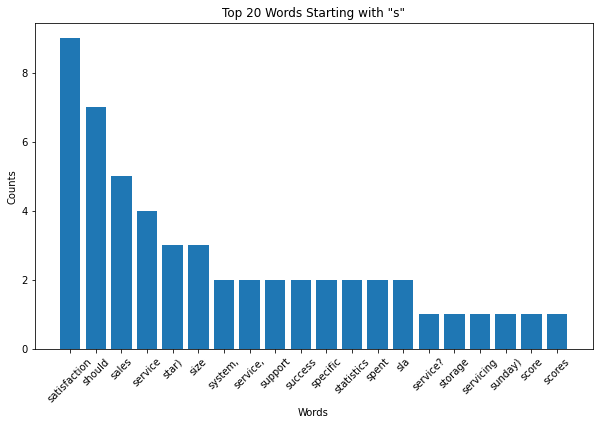

In [0]:
# Assuming data1 is a list of tuples (word, count)
words = [x[0] for x in data1]
counts = [x[1] for x in data1]

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 20 Words Starting with "s"')
plt.xticks(rotation=45)
plt.show()

In [0]:
#words with a sub string "er"

(file
.flatMap(lambda line: line.lower().split())
.filter(lambda word: 'er' in word)
.map(lambda word: (word, 1))
.reduceByKey(lambda x, y: x + y)
.sortBy(lambda rec: rec[1], ascending=False)
.take(10))


Out[303]: [('delivery', 50),
 ('customer', 39),
 ('order', 34),
 ('per', 29),
 ('average', 23),
 ('number', 19),
 ('orders', 16),
 ('customers', 12),
 ('order,', 8),
 ('driver', 7)]

In [0]:
#word ending with "ing" 

(file
.flatMap(lambda line: line.lower().split())
.filter(lambda word: word.endswith('ing'))
.map(lambda word: (word, 1))
.reduceByKey(lambda x, y: x + y)
.sortBy(lambda rec: rec[1], ascending=False)
.take(20))


Out[304]: [('rating', 12),
 ('monitoring', 4),
 ('recurring', 3),
 ('placing', 2),
 ('causing', 2),
 ('servicing', 1),
 ('5.packaging', 1),
 ('(considering', 1),
 ('cancelling', 1),
 ('waiting', 1),
 ('spending', 1),
 ('using', 1),
 ('implementing', 1),
 ('regarding', 1),
 ('on-boarding', 1),
 ('rectifying', 1),
 ('preparing', 1),
 ('incoming', 1),
 ('stocking', 1),
 ('adding', 1)]

In [0]:
(file
.flatMap(lambda line: line.lower().split())
.filter(lambda word: word.endswith('ing'))
.map(lambda word: (word, 1))
.reduceByKey(lambda x, y: x + y)
.sortBy(lambda rec: rec[1], ascending=False)).count()

Out[305]: 35

In [0]:
(file
.flatMap(lambda line: line.lower().split())
.filter(lambda word: word.endswith('ing'))
.map(lambda word: (word, 1))
.reduceByKey(lambda x, y: x + y)).take(10)

Out[306]: [('servicing', 1),
 ('5.packaging', 1),
 ('(considering', 1),
 ('cancelling', 1),
 ('waiting', 1),
 ('placing', 2),
 ('spending', 1),
 ('using', 1),
 ('implementing', 1),
 ('regarding', 1)]

In [0]:
#word ends in ing

(file.flatMap(lambda line: line.split())
.map(lambda word: (  "word ends in -ing" , word.endswith('ing')))
.reduceByKey(lambda x, y: x + y)
.take(1))


Out[307]: [('word ends in -ing', 53)]